In [1]:


import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raultruco/cryptowatson-indicators#egg=cryptowatson-indicators
  %pip install --quiet git+https://github.com/mementum/backtrader.git@0fa63ef4a35dc53cc7320813f8b15480c8f85517#egg=backtrader

import backtrader as bt
from cryptowatsonindicators import datas, strategies, Fng
import requests
requests.packages.urllib3.disable_warnings()
import pprint
pprint = pprint.PrettyPrinter(indent=2, sort_dicts=False, compact=False).pprint   # pprint with defaults

%matplotlib inline

### Global variables

In [7]:
ticker_symbol = "BTCUSDT"    # currently only works with BTCUSDT
indicator_start_date = None            # Limt indicator series to start at specific date or None to use all the history
get_current_index = False
get_index_at = False
plot_fng_and_ticker_chart = True
run_simulator = True

fng = Fng(indicator_start_date=indicator_start_date, ticker_symbol=ticker_symbol)

### Get Fear and Greed index

In [3]:
if get_current_index:
    fng_value = fng.get_current_fng_value()
    fng_details = strategies.FngIndicator._get_fng_value_details(fng_value)
    print('Current FnG:')
    pprint(fng_details)

In [4]:
if get_index_at:
    at_date = '01/04/2022'    # date when look up the Fng

    fng_value = fng.get_fng_value(at_date=at_date)
    fng_details = strategies.FngIndicator._get_fng_value_details(fng_value)
    print(f"FnG at {at_date}:")
    pprint(fng_details)

### Plot Fear and Greed History

<IPython.core.display.Javascript object>

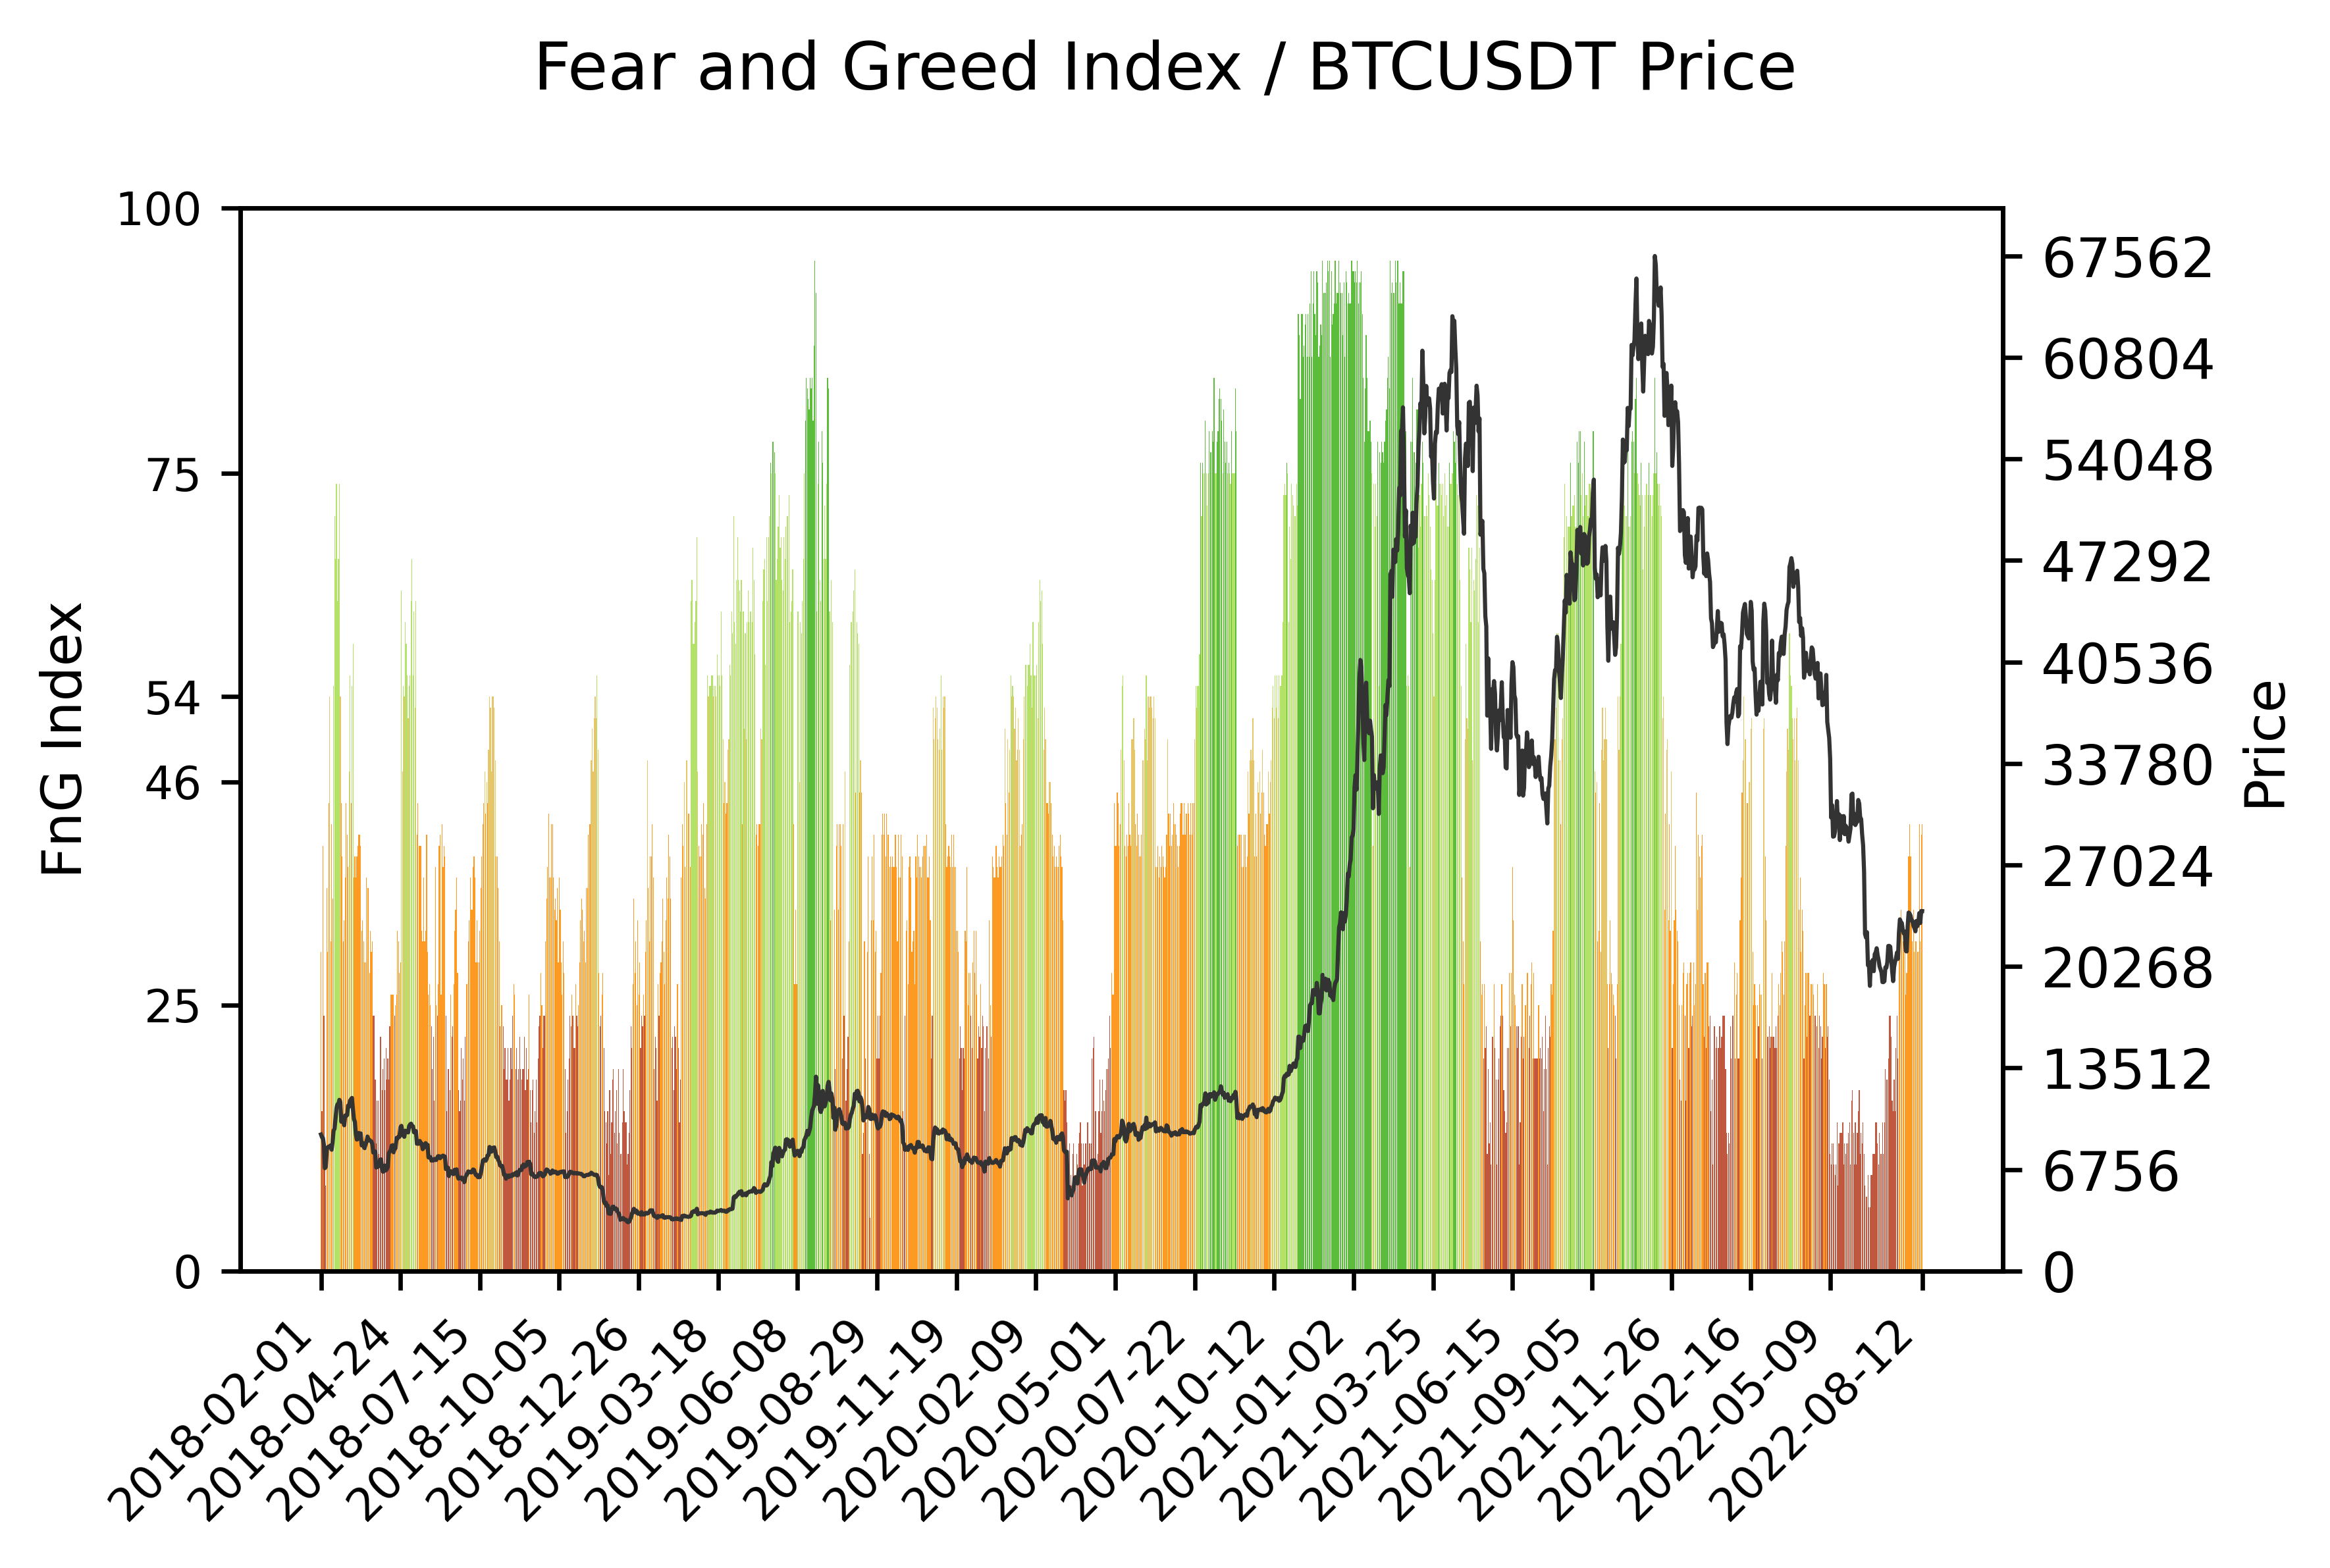

In [9]:
if plot_fng_and_ticker_chart:
    fng.plot_fng_and_ticker_price()

### Simulator

Usage...

<IPython.core.display.Javascript object>

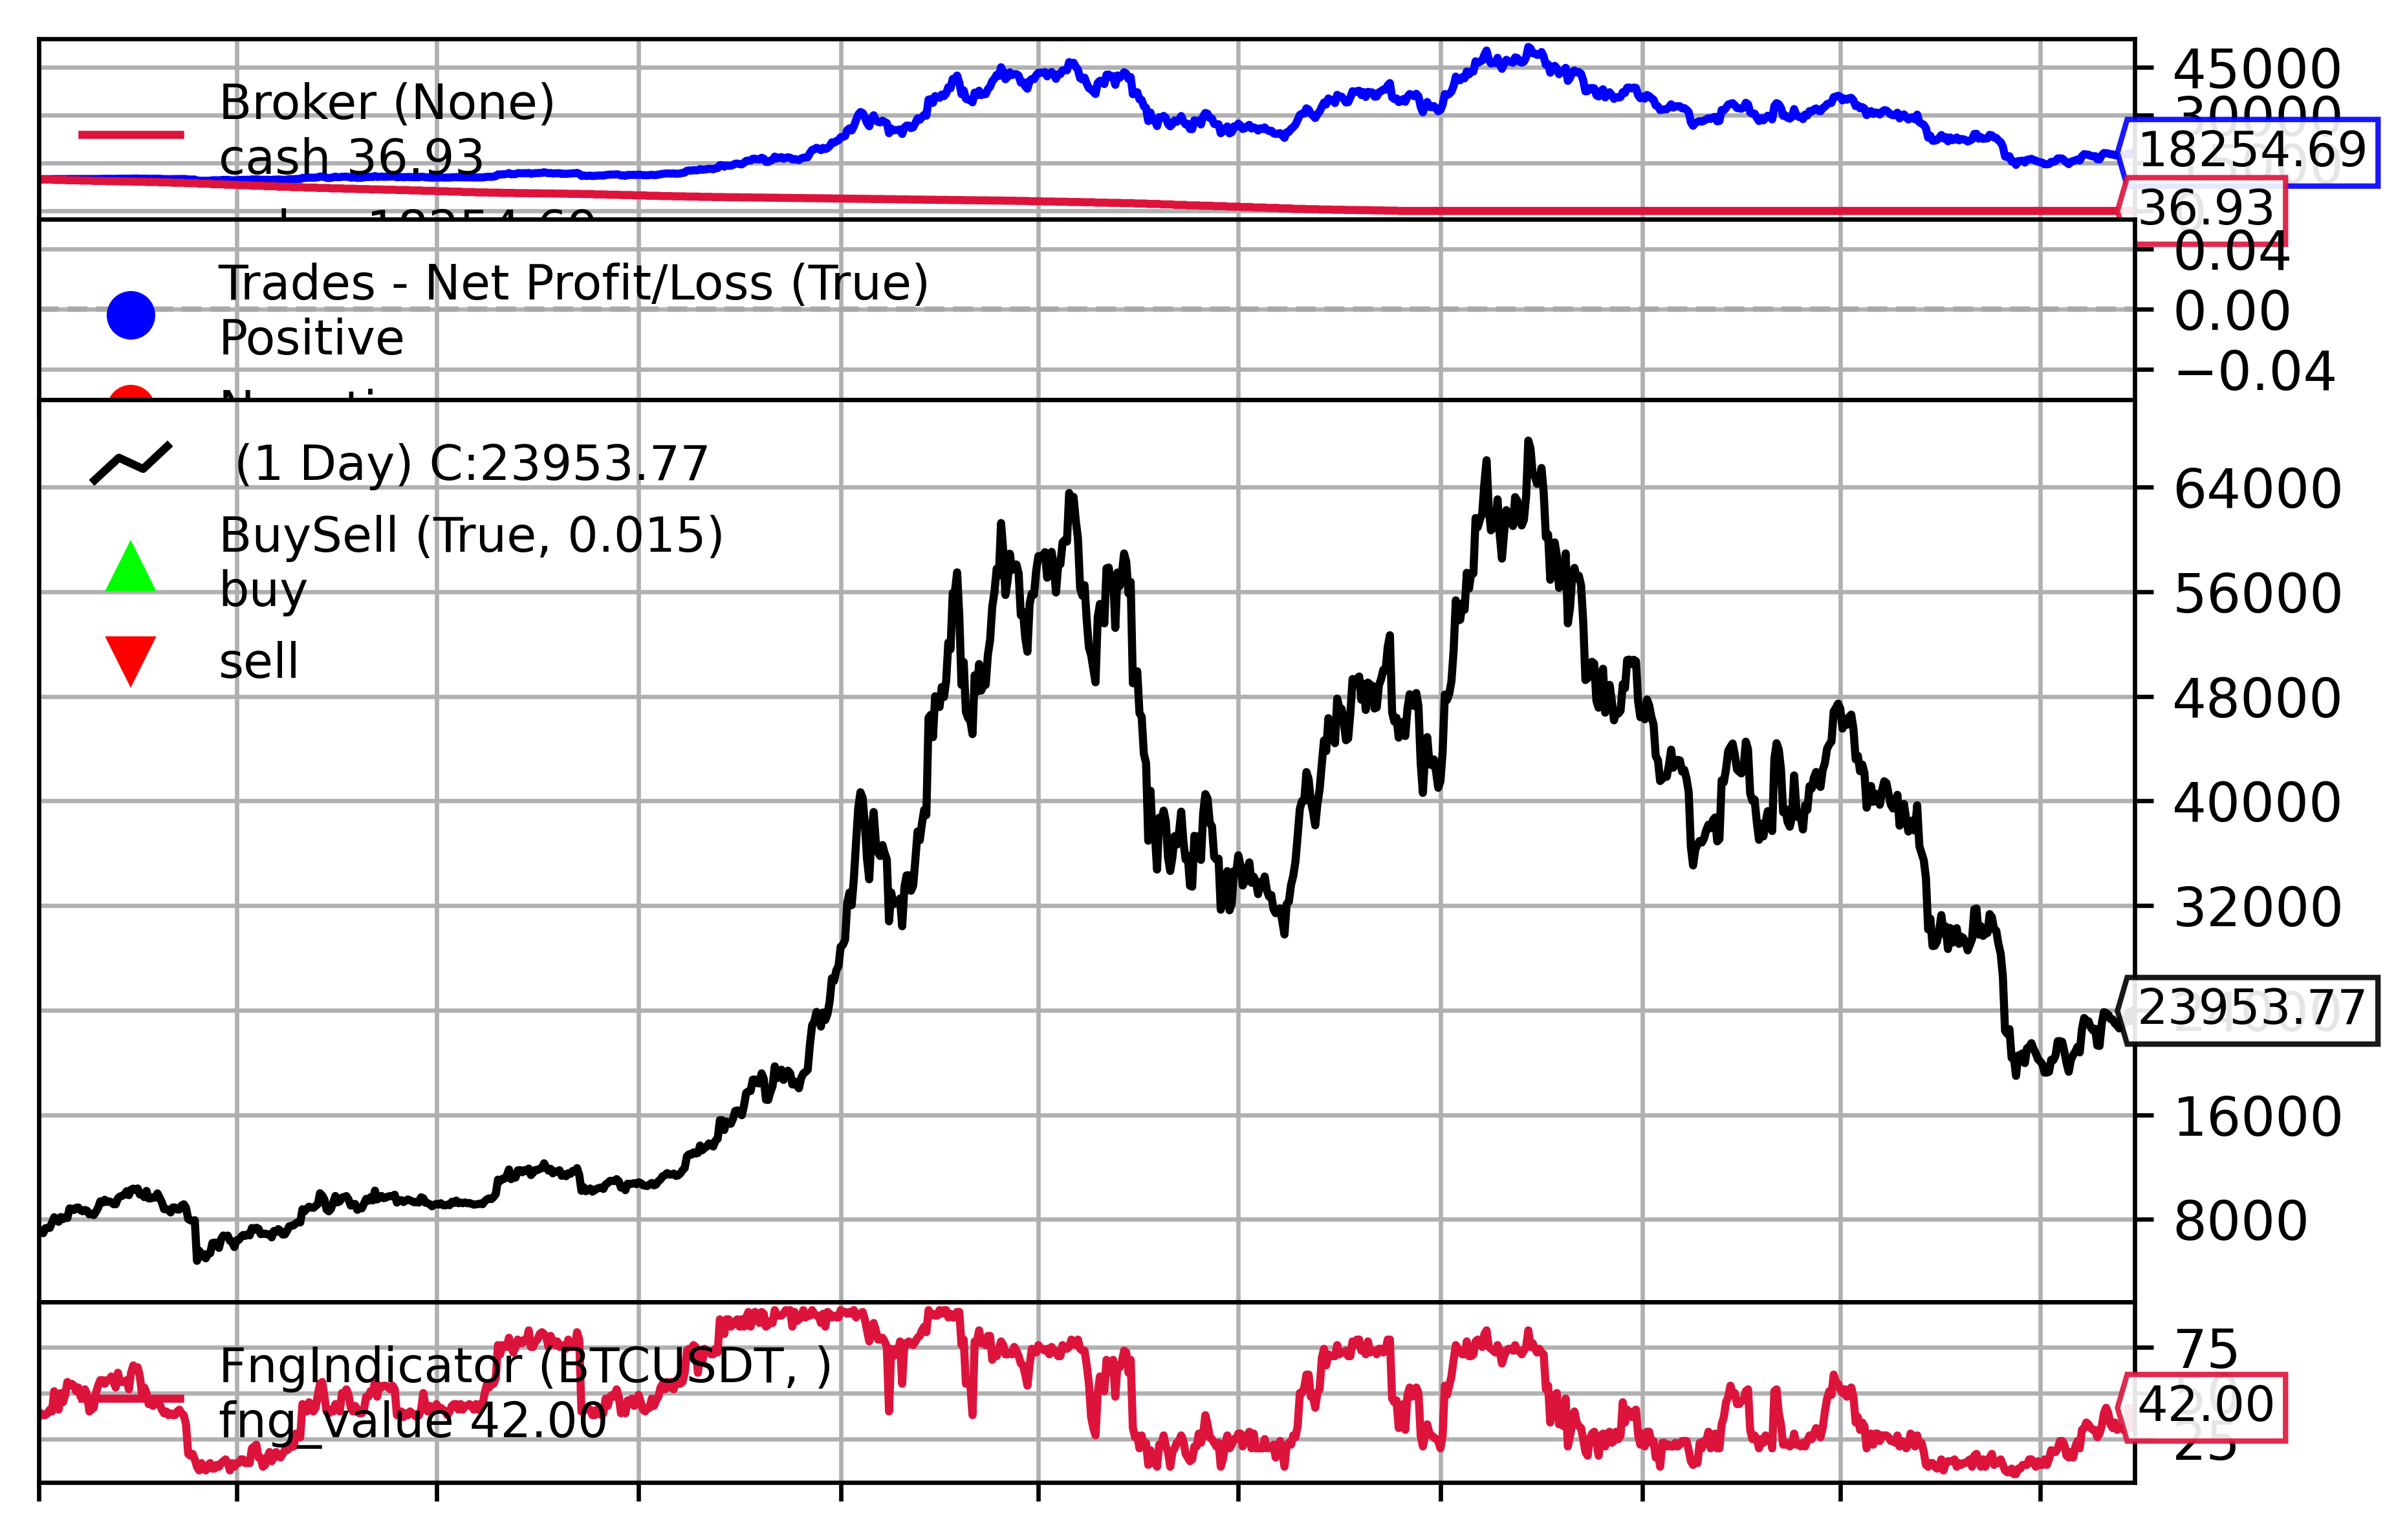

In [12]:

start_date = '01/01/2020'    # start date of the simulation
buy_frequency_days = 5       # Number of days between purchases
buy_amount = 100             # Amount purchased in standard DCA
weight_type = ""             # TBD

if run_simulator:
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=True)

    cerebro.addstrategy(strategies.FngStrategy, buy_amount=buy_amount,
                    buy_frequency_days=buy_frequency_days, weight_type=weight_type, log=False, debug=False)

    # Get data feed
    ticker_data = datas.get_nasdaq_ticker_time_series(start_date=start_date)

    ticker_data_feed = bt.feeds.PandasData(
        dataname=ticker_data,
        datetime=0,
        high=None,
        low=None,
        open=1,     # uses the column 1 ('Value') as open price
        close=1,    # uses the column 1 ('Value') as close price
        volume=None,
        openinterest=None,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(ticker_data_feed)

    # Add cash to the virtual broker
    # cerebro.broker.setcash(100000.0)    # default: 10k

    start_portfolio_value = cerebro.broker.getvalue()
    cerebro.run()
    cerebro.plot(volume=False) # volume=False, iplot=True, style='bar' , stdstats=False

    # end_portfolio_value = cerebro.broker.getvalue()
    # pnl_value = end_portfolio_value - start_portfolio_value
    # pnl_percent = (pnl_value / start_portfolio_value) * 100
    # pnl_sign = '' if pnl_value < 0 else '+'

    # print("----------------------------------------")
    # print(f"{'Start value:':<12} {start_portfolio_value:2f} USD")
    # print(f"{'Final value:':<12} {end_portfolio_value:2f}  USD")
    # print(f"{'PnL:':<11} {pnl_sign}{pnl_value:.2f} USD ({pnl_sign}{pnl_percent:.2f}%)")

    
